## Config

In [4]:
# parameters
INPUT_DATA_PATH = "../data/interim/"
INPUT_PROCESSED_DATA_PATH = "../data/processed/"

YEAR = 2017
SAVE_OUTPUT = True
OUTPUT_DATA_PATH = "../data/interim/"


In [5]:
# Parameters
YEAR = 2023
SAVE_OUTPUT = True


In [6]:
# Import all necessary libraries
import time
start = time.time()
import geopandas as gpd
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
from pathlib import Path


# Load data

In [7]:
#Read observations by hour 
counters_hour = pd.read_parquet(Path(INPUT_DATA_PATH) / f'cleaned_data{YEAR}.parquet')

# Explore the data (shape, columns, head, etc)
print(counters_hour.shape)
print(counters_hour.columns)
counters_hour.head()

(2267136, 11)
Index(['Id_aforament', 'date', 'hour', 'intensity', 'prev_hour_count',
       'Daily_Counts', 'duration', 'Number_of_hrs_data_collected', 'day',
       'month', 'Number_of_days_data_collected'],
      dtype='object')


,Id_aforament,date,hour,intensity,prev_hour_count,Daily_Counts,duration,Number_of_hrs_data_collected,day,month,Number_of_days_data_collected
0,20001,2023-01-01,00,147.0,NaN,4633.0,1,24,1,1,28
1,20001,2023-01-01,01,146.0,NaN,4633.0,1,24,1,1,28
2,20001,2023-01-01,02,150.0,NaN,4633.0,1,24,1,1,28
3,20001,2023-01-01,03,141.0,NaN,4633.0,1,24,1,1,28
4,20001,2023-01-01,04,64.0,NaN,4633.0,1,24,1,1,28


## Fix formats

In [8]:
counters_hour.dtypes

Id_aforament                              int32
date                             datetime64[ns]
hour                                     object
intensity                               float64
prev_hour_count                         float64
Daily_Counts                            float64
duration                                  int64
Number_of_hrs_data_collected              int64
day                                       int32
month                                     int32
Number_of_days_data_collected             int64
dtype: object

In [9]:
counters_hour.rename(columns={'Id_aforament': 'id'}, inplace=True)
counters_hour["intensity"] = counters_hour["intensity"].astype(int)
#Make date column datetime
counters_hour['date'] = pd.to_datetime(counters_hour['date'])
counters_hour["weekday"] = counters_hour["date"].dt.weekday
counters_hour["hour"] = counters_hour["hour"].astype(int)
counters_hour["year"] = counters_hour["date"].dt.year

# Cluster data

## Clustering

### Filter weekdays

In [10]:
essential_attributes = [
    'id',
    'month',
    'weekday', 
    'hour', 
    'intensity', 
]
data_cluster = counters_hour[essential_attributes].copy()
data_cluster=data_cluster[data_cluster["weekday"] < 5]





In [11]:
data_cluster["weekday"].value_counts()

weekday
4    333672
3    329544
0    318216
2    307704
1    306912
Name: count, dtype: int64

### Reshape data

In [12]:
agg_df = data_cluster.groupby(['id', 'hour'])['intensity'].mean().unstack(level=[1])
# Fill missing values if needed
agg_df = agg_df.fillna(0)
agg_df

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
id,,,,,,,,,,,,,,,,,,,,,
20001,302.991228,126.267544,53.925439,30.600877,21.850877,36.153509,65.399123,230.298246,375.026316,392.324561,...,496.517544,503.504386,647.697368,552.508772,620.065789,614.258772,555.929825,423.671053,341.206140,455.951754
20002,287.176471,158.852941,91.441176,55.382353,48.882353,75.911765,114.588235,270.382353,432.676471,427.647059,...,511.882353,555.852941,549.117647,527.088235,631.470588,710.117647,608.147059,481.617647,380.911765,377.647059
20003,109.938144,64.453608,43.247423,26.515464,22.185567,17.927835,23.577320,48.979381,83.164948,100.876289,...,174.175258,205.226804,178.072165,170.391753,204.237113,214.824742,177.618557,156.989691,124.731959,133.371134
20005,35.877660,18.132979,11.308511,5.170213,2.734043,2.021277,7.010638,20.595745,45.420213,71.037234,...,94.638298,114.765957,96.558511,83.962766,116.042553,138.989362,90.335106,69.074468,50.250000,48.553191
20006,159.942982,77.258772,41.785088,23.627193,12.842105,10.228070,11.741228,44.583333,94.149123,138.942982,...,208.530702,257.127193,323.298246,218.030702,229.513158,236.899123,213.640351,195.543860,180.521930,265.842105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20406,16.190000,9.300000,5.300000,4.350000,3.640000,4.190000,8.810000,57.930000,117.930000,53.060000,...,68.970000,53.810000,63.750000,74.740000,89.770000,86.620000,77.580000,52.620000,31.320000,27.920000
20412,13.761905,8.476190,8.761905,2.857143,2.714286,1.666667,2.476190,6.190476,10.666667,17.285714,...,30.761905,25.428571,31.047619,27.238095,27.761905,28.000000,24.619048,22.714286,20.571429,16.571429
20413,87.952381,35.904762,21.952381,14.142857,9.809524,21.857143,19.571429,81.095238,138.380952,213.380952,...,229.095238,199.952381,260.761905,244.714286,279.857143,248.571429,238.333333,207.809524,153.619048,133.285714


### Normalize data

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(agg_df)

### Visualize

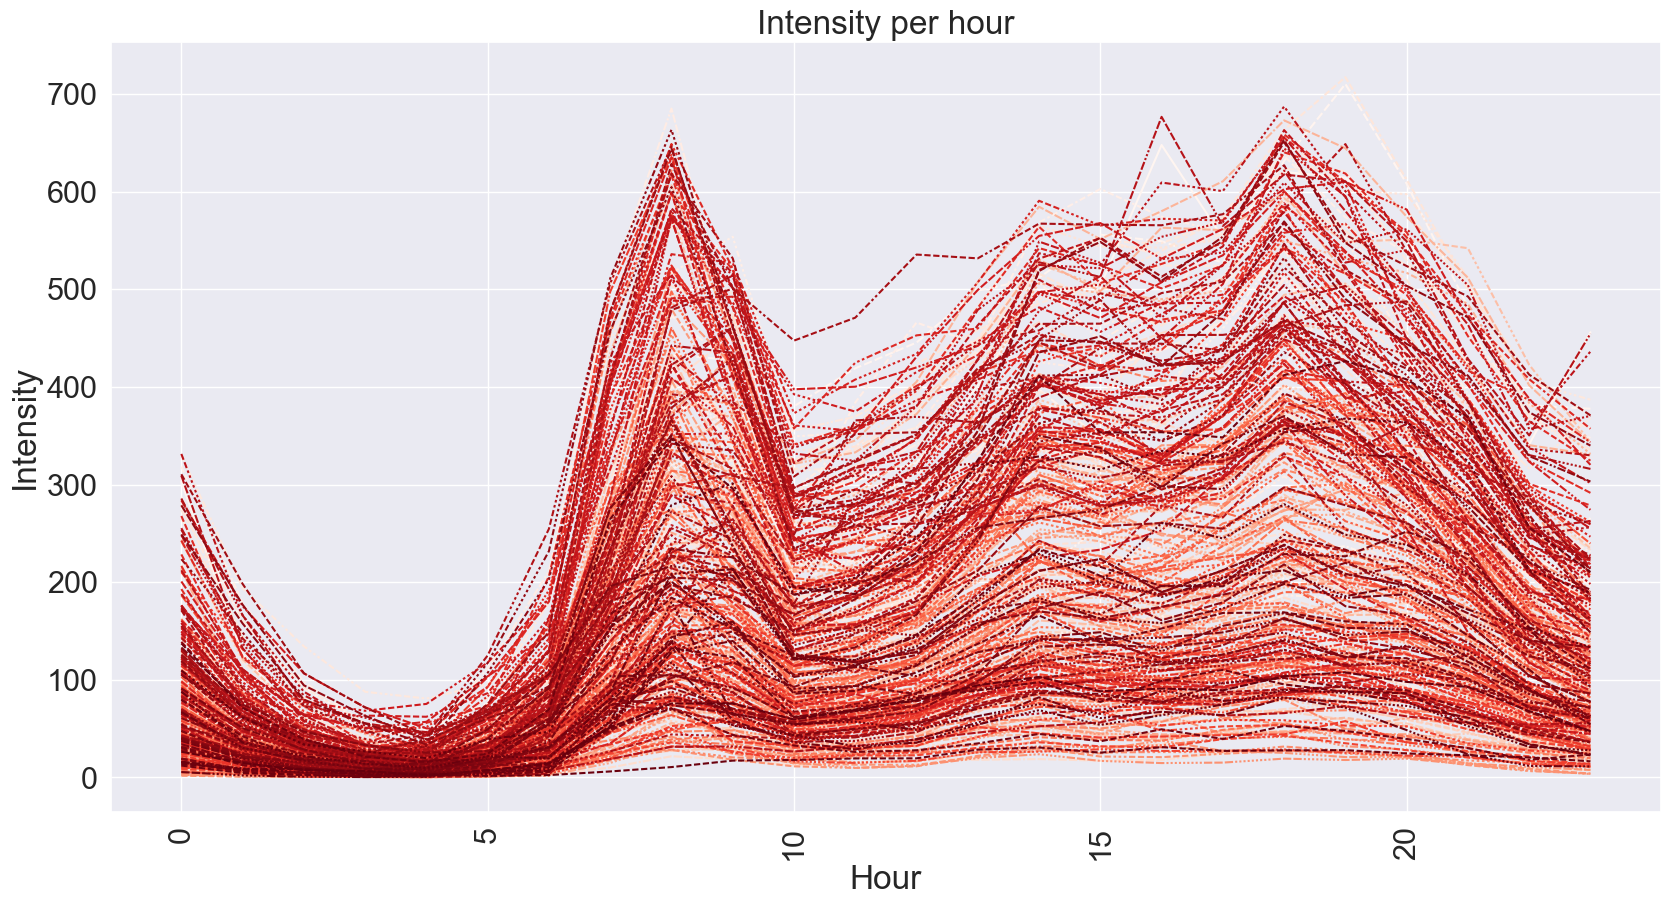

In [14]:
import seaborn as sns

# Set the figure size and font scale
sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale=2.0)

# Create the line plot
ax = sns.lineplot(data=agg_df.T, palette="Reds", legend=False)

# Set the labels and title
plt.xlabel('Hour')
plt.ylabel('Intensity')
plt.title('Intensity per hour')

# Rotate the x-axis labels
plt.xticks(rotation='vertical')

# Show the plot
plt.show()

## Try various clustering algorithms

### Option 1: K-Means

In [15]:
from sklearn.cluster import KMeans

# Choose the number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Assign cluster labels to each sensor
agg_df['cluster'] = clusters


c:\Users\lucal\anaconda3\envs\ridership_model\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [16]:
agg_df['cluster'].value_counts()


cluster
0    168
2    120
1     59
Name: count, dtype: int64

### Visualize

#### Cluster 1

In [17]:
# #Visualize cluster 1
# cluster_1 = agg_df[agg_df['cluster'] == 1].drop(columns=['cluster'])
# ax = sns.lineplot(data=cluster_1.T, palette="Reds", legend=False)
# plt.xlabel('Hour')
# plt.ylabel('Intensity')
# plt.title('Intensity per hour for cluster 1')
# plt.xticks(rotation='vertical')
# plt.show()

### Show all cluster a color each

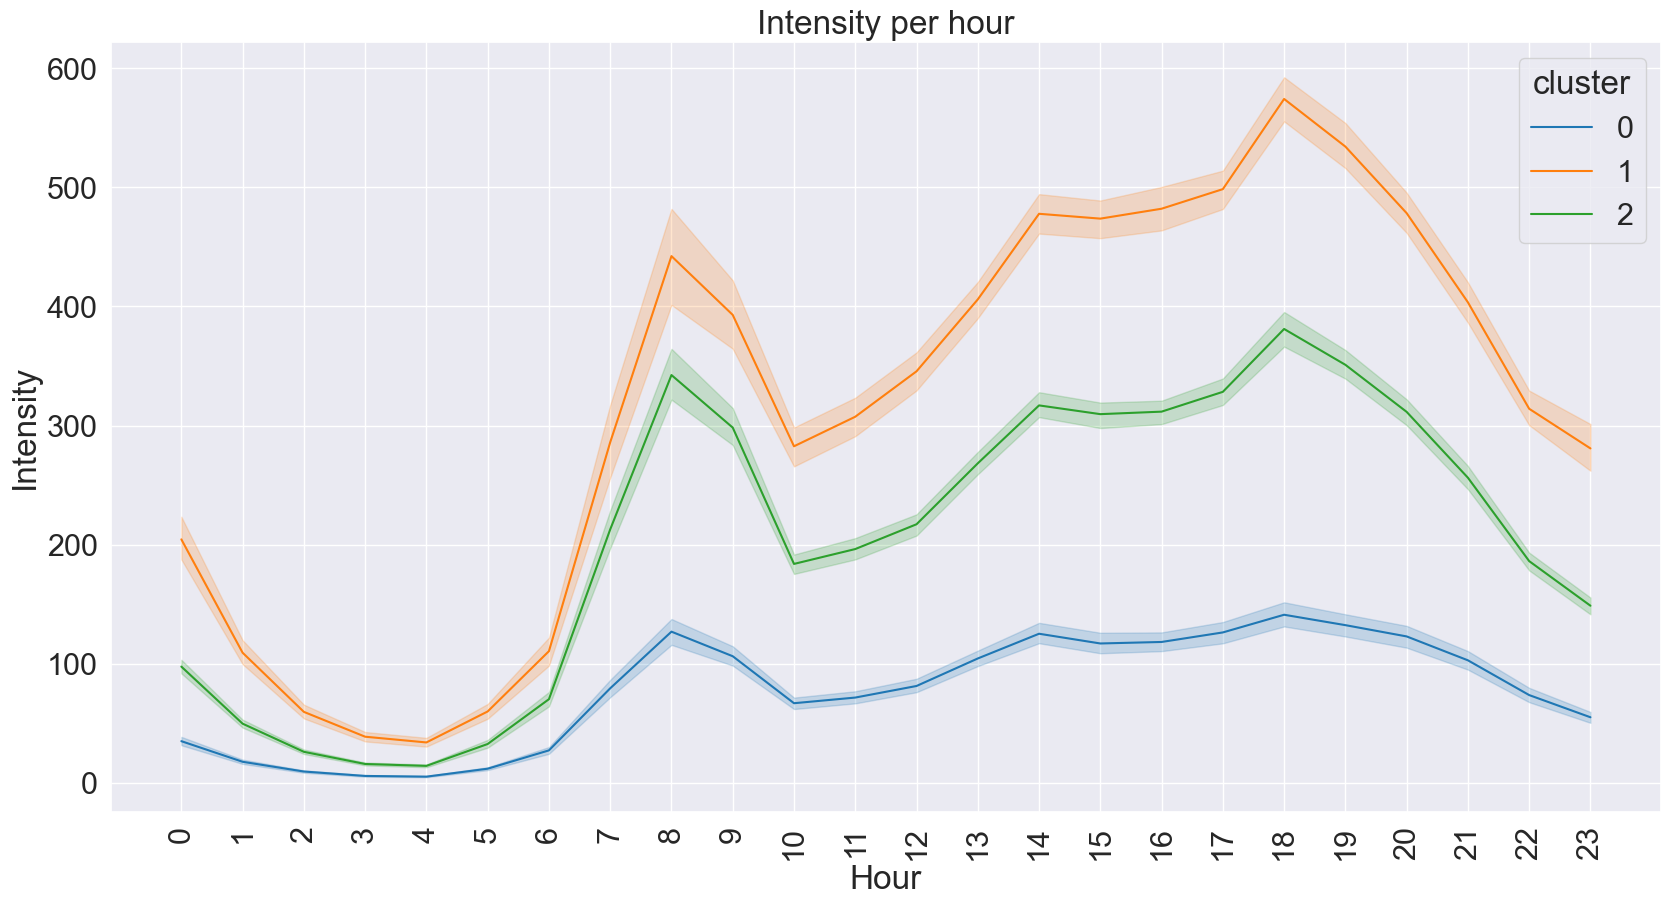

In [18]:
# Show all clusters with each cluster having a different color
agg_df_melted = agg_df.reset_index().melt(id_vars=['id', 'cluster'], var_name='hour', value_name='intensity')

# Create the line plot with hue as cluster
ax = sns.lineplot(data=agg_df_melted, x='hour', y='intensity', hue='cluster', palette="tab10", legend='full')

# Set the labels and title
plt.xlabel('Hour')
plt.ylabel('Intensity')
plt.title('Intensity per hour')

# Set x-axis ticks to show all hours
plt.xticks(ticks=range(24), labels=range(24), rotation='vertical')

# Show the plot
plt.show()

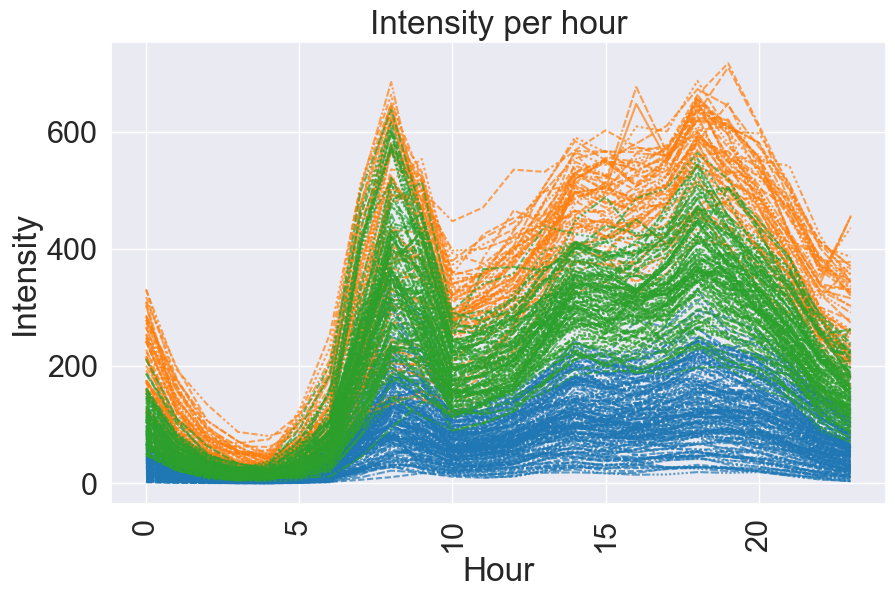

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the DataFrame to long format for Seaborn
agg_long = agg_df.reset_index().melt(id_vars=["id", "cluster"], var_name="hour", value_name="intensity")

# Create the line plot with unique colors per cluster
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=agg_long,
    x="hour",
    y="intensity",
    hue="cluster",  # Color by cluster
    style="id",  # Ensure each row is plotted separately
    palette="tab10",  # Use a categorical palette
    legend=False,
    alpha=0.7
)

# Set the labels and title
plt.xlabel('Hour')
plt.ylabel('Intensity')
plt.title('Intensity per hour')

# Rotate the x-axis labels
plt.xticks(rotation='vertical')

# Show the plot
plt.show()


## Maximum & Minums

In [20]:
analysis_hour = agg_df.copy()
analysis_hour = analysis_hour.reset_index()

# Group by cluster and calculate the mean intensity per hour
analysis_hour.drop(columns=['id'], inplace=True)
analysis_hour = analysis_hour.groupby('cluster').mean()
max_min_cluster = analysis_hour.reset_index().copy()
max_min_cluster = max_min_cluster[["cluster"]]

# Get max hour for each cluster
max_min_cluster['max_hour'] = analysis_hour.idxmax(axis=1)

# Get min hour for each cluster
max_min_cluster['min_hour'] = analysis_hour.idxmin(axis=1)

# Get second highest hour for each cluster
max_min_cluster['second_max_hour'] = analysis_hour.apply(lambda x: x.nlargest(2).idxmin(), axis=1)

max_min_cluster

hour,cluster,max_hour,min_hour,second_max_hour
0,0,18,4,19
1,1,18,4,19
2,2,18,4,19


In [21]:
analysis_hour = agg_df.copy()
analysis_hour = analysis_hour.reset_index()

# Group by cluster and calculate the mean intensity per hour
analysis_hour.drop(columns=['id'], inplace=True)
analysis_hour = analysis_hour.groupby('cluster').mean()
max_min_cluster = analysis_hour.reset_index().copy()
max_min_cluster = max_min_cluster[["cluster"]]

# Get top 5 hours for each cluster
max_min_cluster['top_5_hours'] = analysis_hour.apply(lambda x: x.nlargest(5).index.tolist(), axis=1)

# Get bottom 5 hours for each cluster
max_min_cluster['bottom_5_hours'] = analysis_hour.apply(lambda x: x.nsmallest(5).index.tolist(), axis=1)

max_min_cluster

hour,cluster,top_5_hours,bottom_5_hours
0,0,"[18, 19, 8, 17, 14]","[4, 3, 2, 5, 1]"
1,1,"[18, 19, 17, 16, 20]","[4, 3, 2, 5, 1]"
2,2,"[18, 19, 8, 17, 14]","[4, 3, 2, 5, 1]"


In [22]:
# Detect maximum and minimum intensity for each cluster
agg_df['max_intensity'] = agg_df.drop(columns='cluster').max(axis=1)
agg_df['min_intensity'] = agg_df.drop(columns='cluster').min(axis=1)

# Get the hour with max intensity and min intensity for each cluster
agg_df['hour_max_intensity'] = agg_df.drop(columns=['cluster', 'max_intensity', 'min_intensity']).idxmax(axis=1)
agg_df['hour_min_intensity'] = agg_df.drop(columns=['cluster', 'max_intensity', 'min_intensity']).idxmin(axis=1)

# Group by cluster and get the hour with max intensity and min intensity
agg_df_sorted = agg_df.groupby('cluster').agg({
    'hour_max_intensity': 'first',
    'hour_min_intensity': 'first'
}).reset_index()

# Display the hour with minimum and maximum intensity for each cluster
agg_df_sorted


hour,cluster,hour_max_intensity,hour_min_intensity
0,0,19,5
1,1,16,hour_max_intensity
2,2,16,5


# Save output